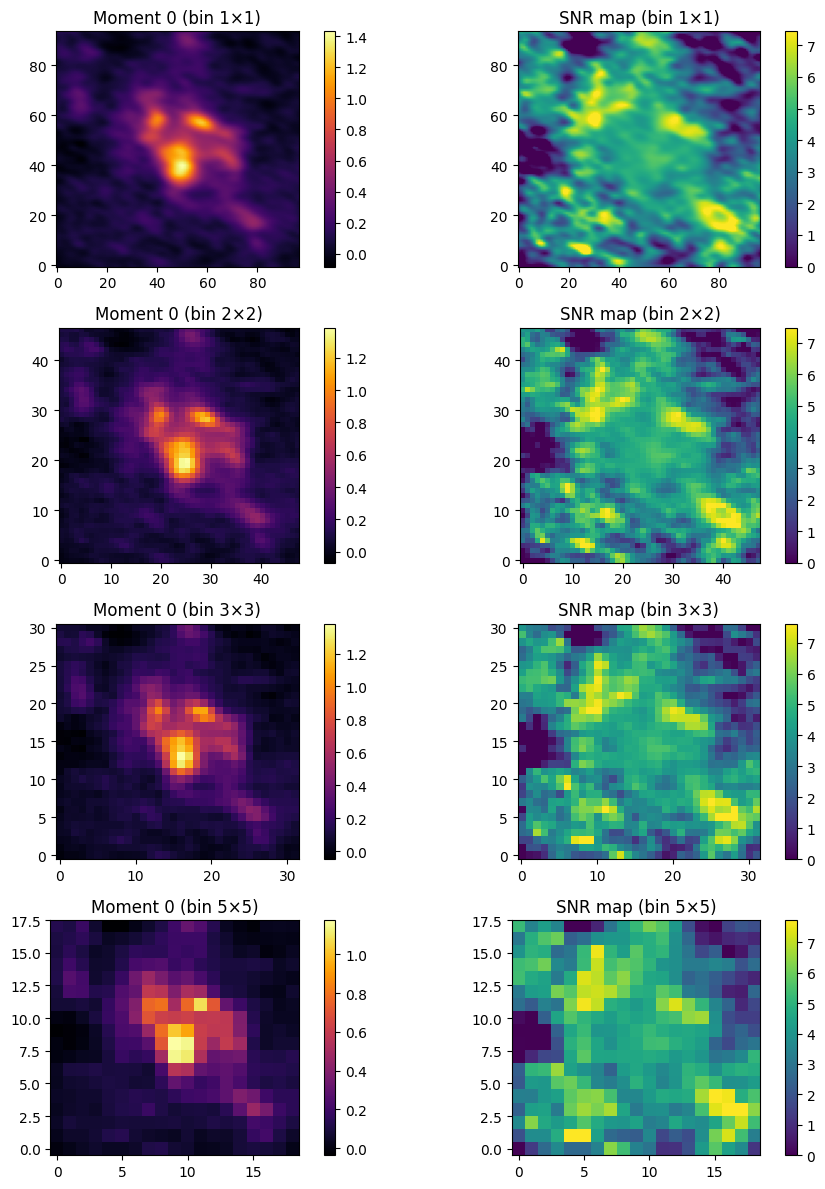

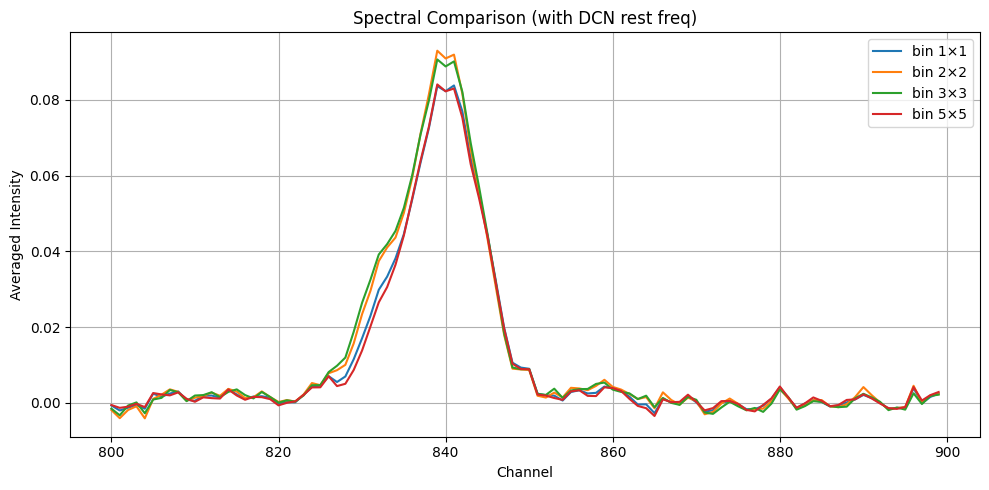

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# ==== 設定輸入檔案與頻道範圍 ====
cube_file = r"/Users/ccc/Desktop/research/baobab/astroimagAna-main/cold_spw0.fits"
v1, v2 = 800, 900  # 要分析的頻道範圍（可自行調整）#DCN channel為784

# ==== 讀取 FITS 資料 ====
data = fits.getdata(cube_file)       # shape: (stokes, freq, y, x)
header = fits.getheader(cube_file)
cube = data[0, :, :, :]              # 取 Stokes I：shape = (freq, y, x)

# ==== 擷取指定頻道區段 ====
subcube = cube[v1:v2, :, :]          # shape: (n_chan, y, x)
channels = np.arange(v1, v2)         # 原始頻道編號（橫軸用） 

# ==== 合併函數 ====
def spatial_bin_cube(cube, bin_factor):
    freq, ny, nx = cube.shape
    new_ny = ny // bin_factor
    new_nx = nx // bin_factor
    cube = cube[:, :new_ny*bin_factor, :new_nx*bin_factor]
    reshaped = cube.reshape(freq, new_ny, bin_factor, new_nx, bin_factor)
    binned = reshaped.mean(axis=(2, 4))
    return binned

# ==== 設定 binning 尺寸 ====
bin_sizes = [1, 2, 3, 5]
moment0_maps = {}
snr_maps = {}

for b in bin_sizes:
    binned = subcube if b == 1 else spatial_bin_cube(subcube, b)
    moment0 = np.nansum(binned, axis=0)
    rms = np.nanstd(binned, axis=0) * np.sqrt(binned.shape[0])
    snr = moment0 / (rms + 1e-10)

    moment0_maps[b] = moment0
    snr_maps[b] = snr

# ==== 顯示 Moment 0 / SNR Map ====
fig, axes = plt.subplots(len(bin_sizes), 2, figsize=(10, 3*len(bin_sizes)))
for i, b in enumerate(bin_sizes):
    ax0, ax1 = axes[i]
    im0 = ax0.imshow(moment0_maps[b], origin='lower', cmap='inferno')
    ax0.set_title(f'Moment 0 (bin {b}×{b})')
    plt.colorbar(im0, ax=ax0, fraction=0.046)

    im1 = ax1.imshow(snr_maps[b], origin='lower', cmap='viridis',
                     vmin=0, vmax=np.nanpercentile(snr_maps[b], 99))
    ax1.set_title(f'SNR map (bin {b}×{b})')
    plt.colorbar(im1, ax=ax1, fraction=0.046)
plt.tight_layout()
plt.show()

# ==== 光譜比較圖（以 channel 為橫軸，加入 rest 頻率標示）====
fig, ax = plt.subplots(figsize=(10, 5))
ny, nx = subcube.shape[1:]
y0, x0 = ny // 2, nx // 2

for b in bin_sizes:
    if b == 1:
        cube_use = subcube
        roi = cube_use[:, y0 - 2:y0 + 3, x0 - 2:x0 + 3]  # 中心 5x5
    else:
        cube_use = spatial_bin_cube(subcube, b)
        yb, xb = y0 // b, x0 // b
        roi = cube_use[:, yb:yb + 1, xb:xb + 1]

    spec = roi.mean(axis=(1, 2))
    ax.plot(np.arange(v1, v2), spec, label=f'bin {b}×{b}')

# ==== 加入 DCN rest 頻率所在 channel 的紅線標示 ====
# 利用前面 header 的參數計算
crval = header['CRVAL3']
cdelt = header['CDELT3']
crpix = header['CRPIX3']
restfreq = 217.238530e9  # Hz

# velocity = 0 km/s 對應的 channel
channel_rest = crpix - crval / cdelt
rest_index = int(round(channel_rest - 1))  # 轉為 Python index

# 若在範圍內才畫
if v1 <= rest_index < v2:
    ax.axvline(rest_index, color='r', linestyle='--', label='DCN rest freq (v=0)')

ax.set_xlabel("Channel")
ax.set_ylabel("Averaged Intensity")
ax.set_title("Spectral Comparison (with DCN rest freq)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
